**Workflow**

Start -> Analyze Sentiment (positive or negative) -> If positive -> Give reply <br>
            
        If negative -> Analyze on basis of (tone, issue_type, emergency)

In [1]:
## LLM used
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

llm.invoke("How are you?")

AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-07T16:34:20.37201Z', 'done': True, 'done_reason': 'stop', 'total_duration': 18201330667, 'load_duration': 1242721042, 'prompt_eval_count': 29, 'prompt_eval_duration': 13532644209, 'eval_count': 47, 'eval_duration': 3423927791, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b994e-e12a-73c3-b167-ed5dc37bab5b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 29, 'output_tokens': 47, 'total_tokens': 76})

In [7]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated, Dict

In [8]:
# state graph data model 
class SupportState(TypedDict):
    """ 
    Keeps the state for Customer Support Workflow customer_comment, final_reply, sentiment, analyzer_feedback
    """
    customer_comment: str 
    final_reply: str 
    sentiment: str 
    analyzer_feedback: dict[str:str]

In [12]:
from pydantic import BaseModel, Field

# this Data Validation class is for Sentiment Analysis 
class SentimentValid(BaseModel):
    """
    Returns whether sentiment is positive or negative
    """
    sentiment: Annotated[Literal['positive', 'negative'], Field(description='Returns whether sentiment is positive or negative')]

# this Data Validation class is for Analyzer for negative comment 
class AnalyzerNegative(BaseModel):
    """
    Returns analysis of comment like issue_type, tone and emergency
    """
    issue_type: Annotated[str, Field(description="Is the issue related to IT, UI/UX, Bug, Support or some other.")]
    tone: Annotated[str, Field(description="Tone in which customer wrote the comment - aggresive, sad, not statisfied, or else")]
    emergency: Annotated[str, Field(description="What is emergency of the situation. Does it required emergency fix?")]

In [19]:
from langchain_core.prompts import PromptTemplate

def sentiment_analyzer(state: SupportState) -> SupportState:
    template = """ 
                You are an intelligent classifier, who used to classify whether comment uploaded by customer is positive or negative.
                <comment> {comment} </comment>
               """
    prompt = PromptTemplate(
        template=template,
        input_variables=['comment']
    )

    llm_sentiment = llm.with_structured_output(SentimentValid)
    chain = prompt | llm_sentiment 
    response = chain.invoke({'comment' : state['customer_comment']})
    return {
        **state,
        'sentiment' : response.sentiment
    }

def reply_for_positive(state: SupportState) -> SupportState:
    template = """ 
                You are a helpful assistant who recieves positive comment of customers and help to create a beautiful short reply to them. 
                <customer_commet> {customer_comment} </customer_comment>
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['customer_comment']
    )
    chain = prompt | llm 
    response = chain.invoke({'customer_comment':state['customer_comment']})
    return {
        **state,
        'final_reply' : response.content
    }

def reply_for_negative(state: SupportState) -> SupportState:
    template = """ 
                You are a helpful assistant who recieves negative comment of customers and analysis of the comment on the basis of issue_type, tone and emergency. Create a satisfactory response to the customer. 
                <customer_commet> {customer_comment} </customer_comment>
                <issue_type> {issue_type} </issue_type>
                <tone> {tone} </tone>
                <emergency> {emergency} </emergency>
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['customer_comment', 'issue_type', 'tone', 'emergency']
    )
    chain = prompt | llm 
    analyzer_feedback = state['analyzer_feedback']
    response = chain.invoke({'customer_comment':state['customer_comment'], 'issue_type': analyzer_feedback['issue_type'], 'tone': analyzer_feedback['tone'], 'emergency': analyzer_feedback['emergency']})
    return {
        **state,
        'final_reply' : response.content
    }

def analyzing_problem_for_negative(state: SupportState) -> SupportState:
    template = """ 
                You are an intelligent agent, who used to research in depth about customer comment and finds out the issue_type (whether IT/UI-UX/Bug/Support else), tone of customer - aggressive or calm, emergency to resolve.
                <comment> {comment} </comment>
               """
    prompt = PromptTemplate(
        template=template,
        input_variables=['comment']
    )

    llm_analyzer = llm.with_structured_output(AnalyzerNegative)
    chain = prompt | llm_analyzer 
    response = chain.invoke({'comment' : state['customer_comment']})
    return {
        **state,
        'analyzer_feedback' : {
            'issue_type' : response.issue_type,
            'tone' : response.tone,
            'emergency' : response.emergency
        }
    }



def check_condition(state: SupportState) -> Literal['reply_for_positive', 'analyzing_problem_for_negative']:
    if state['sentiment'] == 'positive':
        return "reply_for_positive"
    else:
        return "analyzing_problem_for_negative"


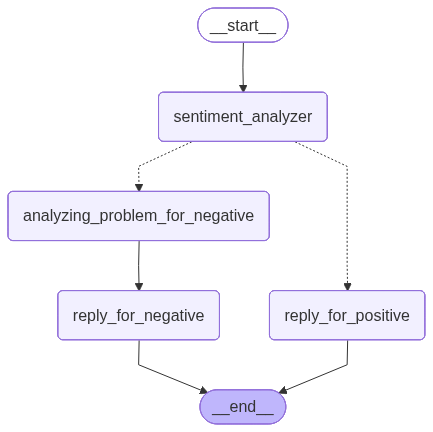

In [20]:
graph = StateGraph(SupportState)

# add node 
graph.add_node('sentiment_analyzer', sentiment_analyzer)
graph.add_node('reply_for_positive', reply_for_positive)
graph.add_node('analyzing_problem_for_negative', analyzing_problem_for_negative)
graph.add_node('reply_for_negative', reply_for_negative)

# add edge 
graph.add_edge(START, 'sentiment_analyzer')
graph.add_conditional_edges('sentiment_analyzer', check_condition)
graph.add_edge('analyzing_problem_for_negative', 'reply_for_negative')

graph.add_edge('reply_for_positive', END)
graph.add_edge('reply_for_negative', END)

# compile graph 
customer_support_service = graph.compile()

# display graph 
from IPython.display import Image 
Image(customer_support_service.get_graph().draw_mermaid_png())

In [21]:
input_state = {'customer_comment' : "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."}

output_state = customer_support_service.invoke(input_state)

In [22]:
from pprint import pprint 
pprint(output_state)

{'analyzer_feedback': {'emergency': 'Yes',
                       'issue_type': 'Bug',
                       'tone': 'Aggressive'},
 'customer_comment': 'I’ve been trying to log in for over an hour now, and the '
                     'app keeps freezing on the authentication screen. I even '
                     'tried reinstalling it, but no luck. This kind of bug is '
                     'unacceptable, especially when it affects basic '
                     'functionality.',
 'final_reply': 'Based on the analysis, I would respond to the customer as '
                'follows:\n'
                '\n'
                '**Response**\n'
                '\n'
                "Dear [Customer's Name],\n"
                '\n'
                "I apologize sincerely for the frustrating experience you've "
                'had with our app. I can imagine how infuriating it must be to '
                'encounter a freezing issue that affects basic functionality, '
                'especially wh